# Motivation
I am interested in what factors have led to disparate outcomes from the Covid-19 pandemic in different communities in the United States. Specifically, I would like to examine the claim that politically right of center communities have fared worse in the pandemic, in terms of per capita deaths, than blue communities and what factors are the cause of any such distributional differences.

# Data
The data for this project comes from three sources. Data from the 2016 presidential election comes from MIT and is licensed under [Creative Commons](creativecommons.org/licenses/by-nc-sa/4.0/). Data about the county Covid deaths comes from USAFacts which is also licensed under [Creative Commons](creativecommons.org/licenses/by-nc-sa/4.0/). The rest of the data is from Census.gov which is considered [Open Data](https://www.census.gov/about/policies/open-gov/open-data.html#:~:text=The%20Census%20Bureau%20is%20committed,scientific%20discovery%2C%20and%20commercial%20activity.).

* [County level vote counts for 2016 president](https://electionlab.mit.edu/data) 

* [County level covid fatalities by date](https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/) 

* [County demographic estimates](https://www.census.gov/newsroom/press-kits/2020/population-estimates-detailed.html)

* [County poverty and median income estimates](https://www.census.gov/data/datasets/2016/demo/saipe/2016-state-and-county.html)

* [County land area to establish density](https://www2.census.gov/library/publications/2011/compendia/usa-counties/excel/LND01.xls)

* [Map of abbreviations used in census data for reference](https://www2.census.gov/library/publications/2011/compendia/usa-counties/excel/Mastdata.xls)

# Research questions:
The main hypothesis that will be tested is:
After controlling for likely confounders such as county poverty rate, county median household income, county population density and county population total, is there an association between the difference in total Clinton and Trump voters that a county had in the 2016 election and fatalities attributed to Covid within that county (it would have been ideal to have 2020 Biden-Trump data, but at the time that the project was started it was not available.) This relationship will be explored in a couple of ways, discussed under the methodology.

# Background/Existing work:
I haven't found this analysis performed anywhere yet, but [this study](https://www.medrxiv.org/content/10.1101/2020.10.16.20213892v2) is similar to the one I will perform only at the state level rather than county. [Here is another similar study](https://www.nature.com/articles/s41562-020-00977-7#data-availability), which looked at smartphone data to test for an association between voting for Trump and reduced social distancing. The authors established this effect, and found that it also associated to increases in infection and fatality growth rates.

In June the media started writing a lot about the increase of Covid cases in red states. For instance, [this article](https://apnews.com/article/7aa2fcf7955333834e01a7f9217c77d2) shows red states matching blue states in new daily cases per million by mid June. Also, [here is a Washington post article](https://www.washingtonpost.com/politics/2020/06/24/shift-coronavirus-primarily-red-states-is-complete-its-not-that-simple/) from late June discussing differences in new cases in red and blue states and counties.

[Here is an article](https://thewell.unc.edu/2020/06/22/debunking-the-partisan-narrative/) from UNC discussing potential non-partisan drivers that may have contributed to state level differences in Covid responses.

# Methodology:
The most straightforward approach will be to construct a multiple linear regression model with county per capita deaths as response, and the difference between Clinton and Trump voters along with other potentially confounding variables as regressors. This will allow for the effect of voting proportion within a county on per capita deaths due to Covid to be tested while controlling for the potential confounders. 
Evidence of an effect from voting distribution on Covid deaths will have also likely changed over time. For instance, the US epidemic was seeded first in major cities which tend to lean heavily democratic, and took time to spread through the rest of the country. Also, it took time for our response to the epidemic to become politicized and for partisan narratives to become established. Because of this it will also be interesting to perform the analysis at different periods over the last 9 months to see how the effect has changed over time. 

# Notebook Requirements
This notebook was authored using an anaconda 4.9.2 environment. Other than the packages bundled with the anaconda install, [the ruptures library](https://github.com/deepcharles/ruptures) was used. To install issue:
    
    conda install -c conda-forge ruptures

# Data collation and cleaning
In the below sections we collect the data we will be using, manipulate it into a usable form and join it together to create the data sets we are interested in. 

We start by defining some global config, declaring our imports and then go on to download our data.

In [1]:
#global config
ALWAYS_REFRESH = False
LAST_DATE_OF_ANALYSIS = '12/4/20'
USER_AGENT = "Your Name"

#imports
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import urllib
from sklearn.linear_model import LinearRegression
from functools import reduce
from os import path
import matplotlib.pyplot as plt
import ruptures as rpt
import numpy as np

COUNTY_COVID_DEATHS_URL = 'https://static.usafacts.org/public/data/covid-19/covid_deaths_usafacts.csv?_ga=2.225548954.169180442.1607198910-55390823.1606980097'
COUNTY_COVID_DEATHS_CSV = 'county_covid_deaths.csv'
COUNTY_POPULATION_ESTIMATES_URL = 'https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv'
COUNTY_POPULATION_CSV = 'county_population.csv'
COUNTY_INCOME_URL = 'https://www2.census.gov/programs-surveys/saipe/datasets/2016/2016-state-and-county/est16all.xls'
COUNTY_INCOME_XLS = 'county_income.xls'
COUNTY_VOTES_URL = 'https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/VOQCHQ/HEIJCQ'
COUNTY_VOTES_TSV = 'county_votes_2016.tsv'
COUNTY_LAND_AREA_URL = 'https://www2.census.gov/library/publications/2011/compendia/usa-counties/excel/LND01.xls'
COUNTY_LAND_AREA_XLS = 'county_land_area.xls'
COUNTY_DEMOGRAPHICS_URL = 'https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/asrh/cc-est2019-alldata.csv'
COUNTY_DEMOGRAPHICS_CSV = 'county_demographics.csv'

def download_as_user_and_save(url, fname, overwrite=False):
    if overwrite or not path.exists(fname):
        fancy_opener = urllib.request.FancyURLopener()
        fancy_opener.addheader('User-Agent', USER_AGENT)
        filename, headers = fancy_opener.retrieve(url, fname)
def download_file(url, fname, overwrite=False):
    if overwrite or not path.exists(fname):
        urllib.request.urlretrieve(url, fname)

#download_file(NYT_COUNTY_COVID_URL, NYT_COUNTY_COVID_CSV, ALWAYS_REFRESH)
download_as_user_and_save(COUNTY_COVID_DEATHS_URL, COUNTY_COVID_DEATHS_CSV, ALWAYS_REFRESH)
download_file(COUNTY_DEMOGRAPHICS_URL, COUNTY_DEMOGRAPHICS_CSV)
download_file(COUNTY_POPULATION_ESTIMATES_URL, COUNTY_POPULATION_CSV)
download_file(COUNTY_VOTES_URL, COUNTY_VOTES_TSV)
download_file(COUNTY_LAND_AREA_URL, COUNTY_LAND_AREA_XLS)
download_file(COUNTY_INCOME_URL, COUNTY_INCOME_XLS)

C:\Users\willi\anaconda3\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: FancyURLopener style of invoking requests is deprecated. Use newer urlopen functions/methods


Here we read in the county covid death datasets, keeping only the county fips code (a unique identifier for US counties), county and state names, and the daily death totals up to our fixed ending date configured in our global state above.

In [2]:
county_deaths_df = pd.read_csv(COUNTY_COVID_DEATHS_CSV, dtype= {'countyFIPS': str})

# now fix December 4 as last day of analysis:
first_date_not_analyzed = county_deaths_df.columns.get_loc(LAST_DATE_OF_ANALYSIS)+1
col_count = len(county_deaths_df.columns)
county_deaths_df = county_deaths_df.drop(columns=county_deaths_df.columns[range(first_date_not_analyzed, col_count)])

# keep only the death counts, fips, state and county names
county_deaths_df['fips'] = county_deaths_df['countyFIPS']
county_deaths_df['fips'] = county_deaths_df.fips.apply(lambda fips:'0' + fips if len(fips) == 4 else fips)
county_deaths_df = county_deaths_df.drop(columns=['stateFIPS','countyFIPS'])

# drop statewide counts
county_deaths_df = county_deaths_df[county_deaths_df.fips != '0']

Now we read into memory the county demographic data and keep only the fips, the most recent year's data, the age group column with all values except 0 which indicates the total over all age groups, and the total population column which has the number of individuals in that age group. Then we pivot over the counties and rename the age groups using their friendly names. Finally we add a column for the sum of all age groups for the estimated total county population:

In [3]:
county_demographics_df = pd.read_csv(COUNTY_DEMOGRAPHICS_CSV, usecols = ['AGEGRP','STATE','COUNTY','YEAR','TOT_POP'], dtype= {'STATE': str, 'COUNTY': str})
county_demographics_df['fips'] = county_demographics_df['STATE'] + county_demographics_df['COUNTY']
county_demographics_df = county_demographics_df[county_demographics_df.YEAR == 12]
county_demographics_df = county_demographics_df[county_demographics_df.AGEGRP != 0]
county_demographics_df = county_demographics_df.drop(columns = ['STATE','COUNTY','YEAR'])
age_groups = ['0-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79','80-84','85_']
age_group_map = dict(zip(range(1, 19), age_groups))
county_demographics_df = county_demographics_df.pivot_table(index='fips', columns = 'AGEGRP', values = 'TOT_POP').reset_index()
county_demographics_df = county_demographics_df.rename(age_group_map,axis=1)
county_demographics_df['total_population'] = county_demographics_df[age_groups].sum(axis=1)

We next read in the county voting data, pivot it over the fips codes adding the candidate vote counts into new columns for each distinct candidate (Clinton, Trump and other.) We then drop the other column:

In [4]:
county_votes_df = pd.read_csv(COUNTY_VOTES_TSV, sep = '\t', dtype= {'FIPS': str})
county_votes_df = county_votes_df.rename(columns={'FIPS': "fips"})
county_votes_df = county_votes_df[county_votes_df['year'] == 2016]
county_votes_df = county_votes_df[['fips','candidatevotes','candidate']]

# pivot over FIPS and place candidate vote count in a new column identifying them
county_votes_df = county_votes_df.pivot_table(index='fips', columns='candidate',values='candidatevotes').reset_index()
county_votes_df['clinton_count'] = county_votes_df['Hillary Clinton'] 
county_votes_df['trump_count'] = county_votes_df['Donald Trump'] 
county_votes_df = county_votes_df.drop(columns=['Hillary Clinton','Donald Trump'])
county_votes_df['fips'] = county_votes_df.fips.apply(lambda fips:'0' + fips if len(fips) == 4 else fips)
county_votes_df = county_votes_df.drop(columns=['Other'])

Now we read in the county land area data, keeping only the county land area column and as usual the fips code:

In [5]:
county_land_area = pd.read_excel(COUNTY_LAND_AREA_XLS, 'Sheet1', index_col=None, dtype= {'STCOU': str})
county_land_area = county_land_area[['LND110210D', 'STCOU']]
county_land_area['fips'] = county_land_area['STCOU']
county_land_area['county_area'] = county_land_area['LND110210D']
county_land_area = county_land_area.drop(columns=['STCOU', 'LND110210D'])

Last we read in the county income data, keeping the median household income and poverty data: 

In [6]:
county_income_df = pd.read_excel(COUNTY_INCOME_XLS, 'est16ALL', index_col=None, skiprows = [0, 1, 2], dtype= {'State FIPS Code': str, 'County FIPS Code': str}) 
county_income_df['fips'] = county_income_df['State FIPS Code'] + county_income_df['County FIPS Code']
county_income_df = county_income_df[['fips', 'Poverty Estimate, All Ages', 'Median Household Income']]
county_income_df = county_income_df.rename(columns={'Poverty Estimate, All Ages': "poverty", 'Median Household Income' : 'median_household_income'})
county_income_df['poverty'] = county_income_df['poverty'].replace({'.': '0'})
county_income_df['median_household_income'] = county_income_df['median_household_income'].replace({'.': '0'})
county_income_df['poverty'] = county_income_df['poverty'].astype('int64')
county_income_df['median_household_income'] = county_income_df['median_household_income'].astype('int64')

# Change Point Analysis
We now take an aside to perform a change point analysis on the cumulative death time series. This sort of analysis predicts places in a time series where there is a significant change in slope. Intuitively, it is trying to tell when there were significant changes in the underlying mechanism that generates the time series. We will use these points later as the dates up to when we will perform our different regression analyses. 

We first aggregate deaths over the counties to get the national cumulative death series. We then use the rupture library to perform the change point analysis and graph the sections of change:

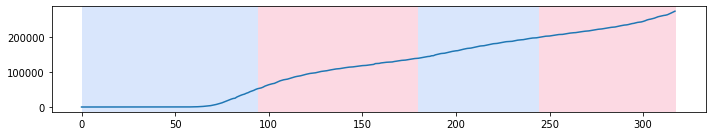

Change points:95,180,245,318


In [7]:
aggregate_death_df = county_deaths_df.drop(columns=['fips','State','County Name']).T
aggregate_death_df['Deaths'] = aggregate_death_df.sum(axis=1)
aggregate_death_df = aggregate_death_df.reset_index()
aggregate_death_df = aggregate_death_df[['index', 'Deaths']]
aggregate_death_df = aggregate_death_df.rename({'index' : 'Date'})
aggregate_death_df['Log Transformed Deaths'] = np.log2(1 + aggregate_death_df['Deaths'])

algo = rpt.Pelt(model="rbf").fit(aggregate_death_df['Deaths'].to_frame())
changepoints = algo.predict(pen=10)

rpt.display(aggregate_death_df['Deaths'], changepoints)
plt.show()

print("Change points:" + ','.join([str(i) for i in changepoints]))

We now convert the indices from the change point analysis to actual dates, which denote the column names for the county death totals on those days:

In [8]:
change_dates = [county_deaths_df.columns[1+i] for i in changepoints]
print(", ".join(change_dates))

4/25/20, 7/19/20, 9/22/20, 12/4/20


We now join all of the data together into one dataframe to use in our regression analysis later. We then print a few rows from our join table:

In [9]:
component_data_sets = [county_deaths_df[change_dates + ['fips']], county_votes_df, county_land_area, county_income_df, county_demographics_df]

def merge_tables(dataframes):
    return reduce(lambda left, right: pd.merge(left, right, on='fips', how="inner"), dataframes)

merged = merge_tables(component_data_sets)
print(merged.head())

   4/25/20  7/19/20  9/22/20  12/4/20   fips  clinton_count  trump_count  \
0        2       21       25       41  01001         5936.0      18172.0   
1        2       15       49      138  01003        18458.0      72883.0   
2        0        3        7       29  01005         4871.0       5454.0   
3        0        2       10       38  01007         1874.0       6738.0   
4        0        1       14       46  01009         2156.0      22859.0   

   county_area  poverty  median_household_income  ...  45-49  50-54  55-59  \
0       594.44     7444                    54487  ...   3877   3775   3896   
1      1589.78    24005                    56460  ...  14472  14319  16267   
2       884.88     6787                    32884  ...   1578   1504   1709   
3       622.58     4099                    43079  ...   1622   1530   1516   
4       644.78     8033                    47213  ...   3868   3842   3986   

   60-64  65-69  70-74  75-79  80-84   85_  total_population  
0   3370   

# Analysis
First let's look at the relationship between some of our variables. First we define a metric that captures the voting relationship we are interested in, namely the intracounty disparity between Clinton and Trump voters in 2016, by subtracting the total Trump vote counts in each county by the total Clinton votes there. To keep the values all on the interval (-1, 1) we then divide the metric by the total population of that county. Therefore, numbers between -1 and 0 will indicate an excess of Trump voters, while numbers between 0 and 1 will indicate more Clinton voters.

In [10]:
population_density = merged['total_population']/merged['county_area']
per_capita_voting_metric = (merged['clinton_count']-merged['trump_count'])/merged['total_population']
most_recent_deaths_per_capita = merged[change_dates[-1]]/merged['total_population']

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (36, 24)
rcParams['legend.fontsize'] = 16
rcParams['axes.labelsize'] = 16

Now let's take a look at some of the relationships between the regressor variables. We'll start by looking at the relationship between voting tendency and county population density. It is common knowledge that more rural areas tend to lean more to the right politically, while urban areas with higher densities lean more to the left. So if we graph the voting metric against the population density, we expect to see that density values roughly increase with the voting metric, and that is in fact what we find:

Text(0, 0.5, '$population density$')

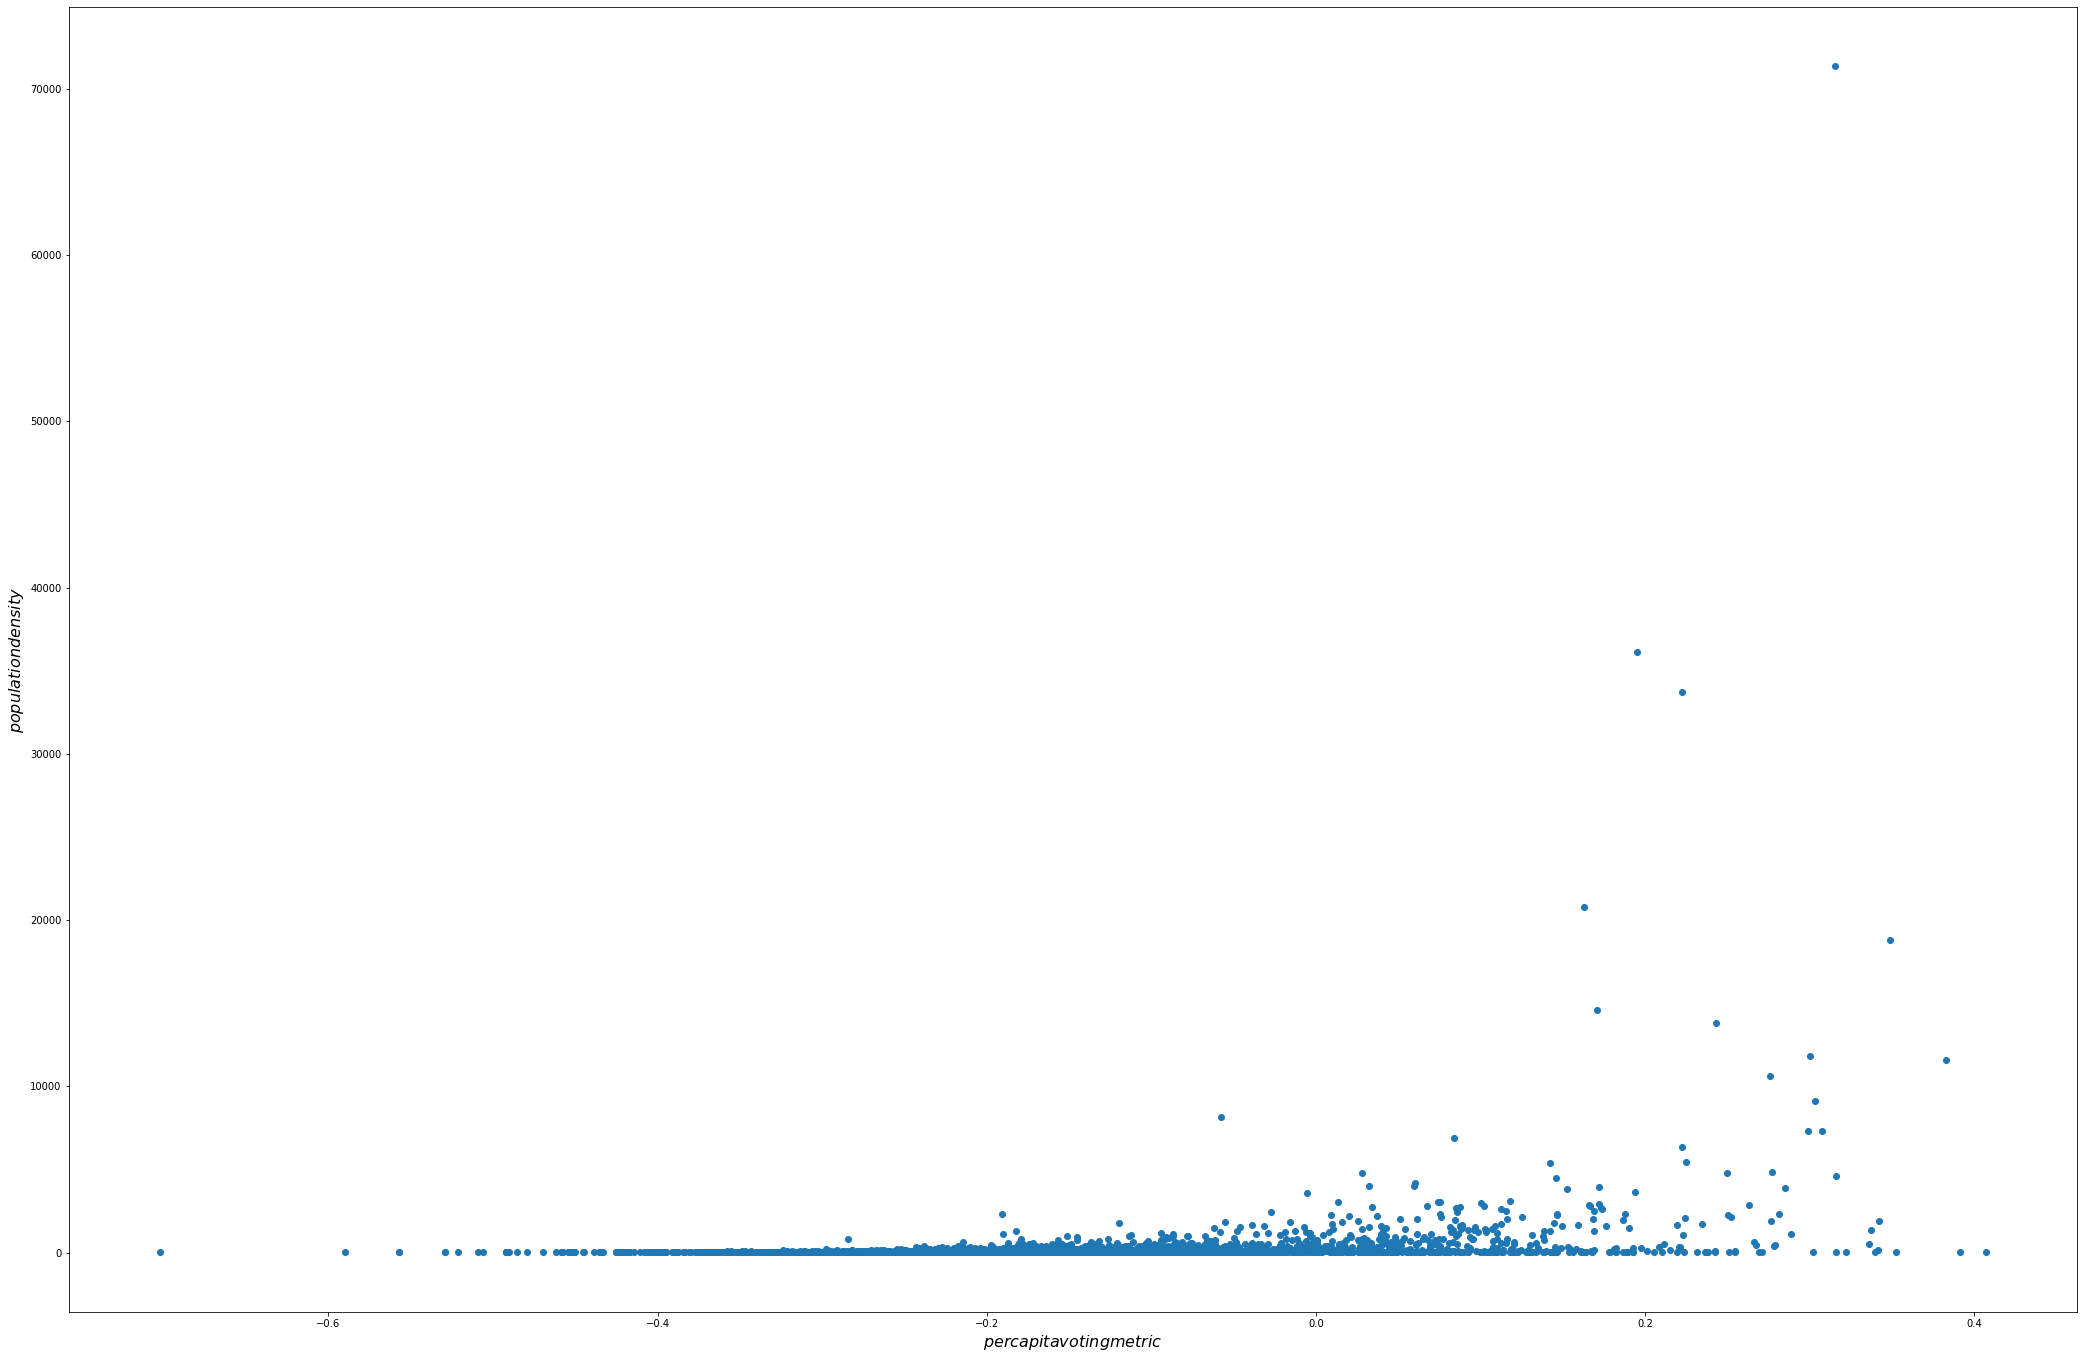

In [11]:
plt.plot(per_capita_voting_metric, population_density, 'o', label='data')
plt.xlabel('$per capita voting metric$')
plt.ylabel('$population density$')

It's also common knowledge that wealth is disproportionately concentrated in left leaning regions of the country. So let's take a look at plots of the economic metrics in our dataset against the per capita voting metric. First, median household income:

Text(0, 0.5, 'Median household income')

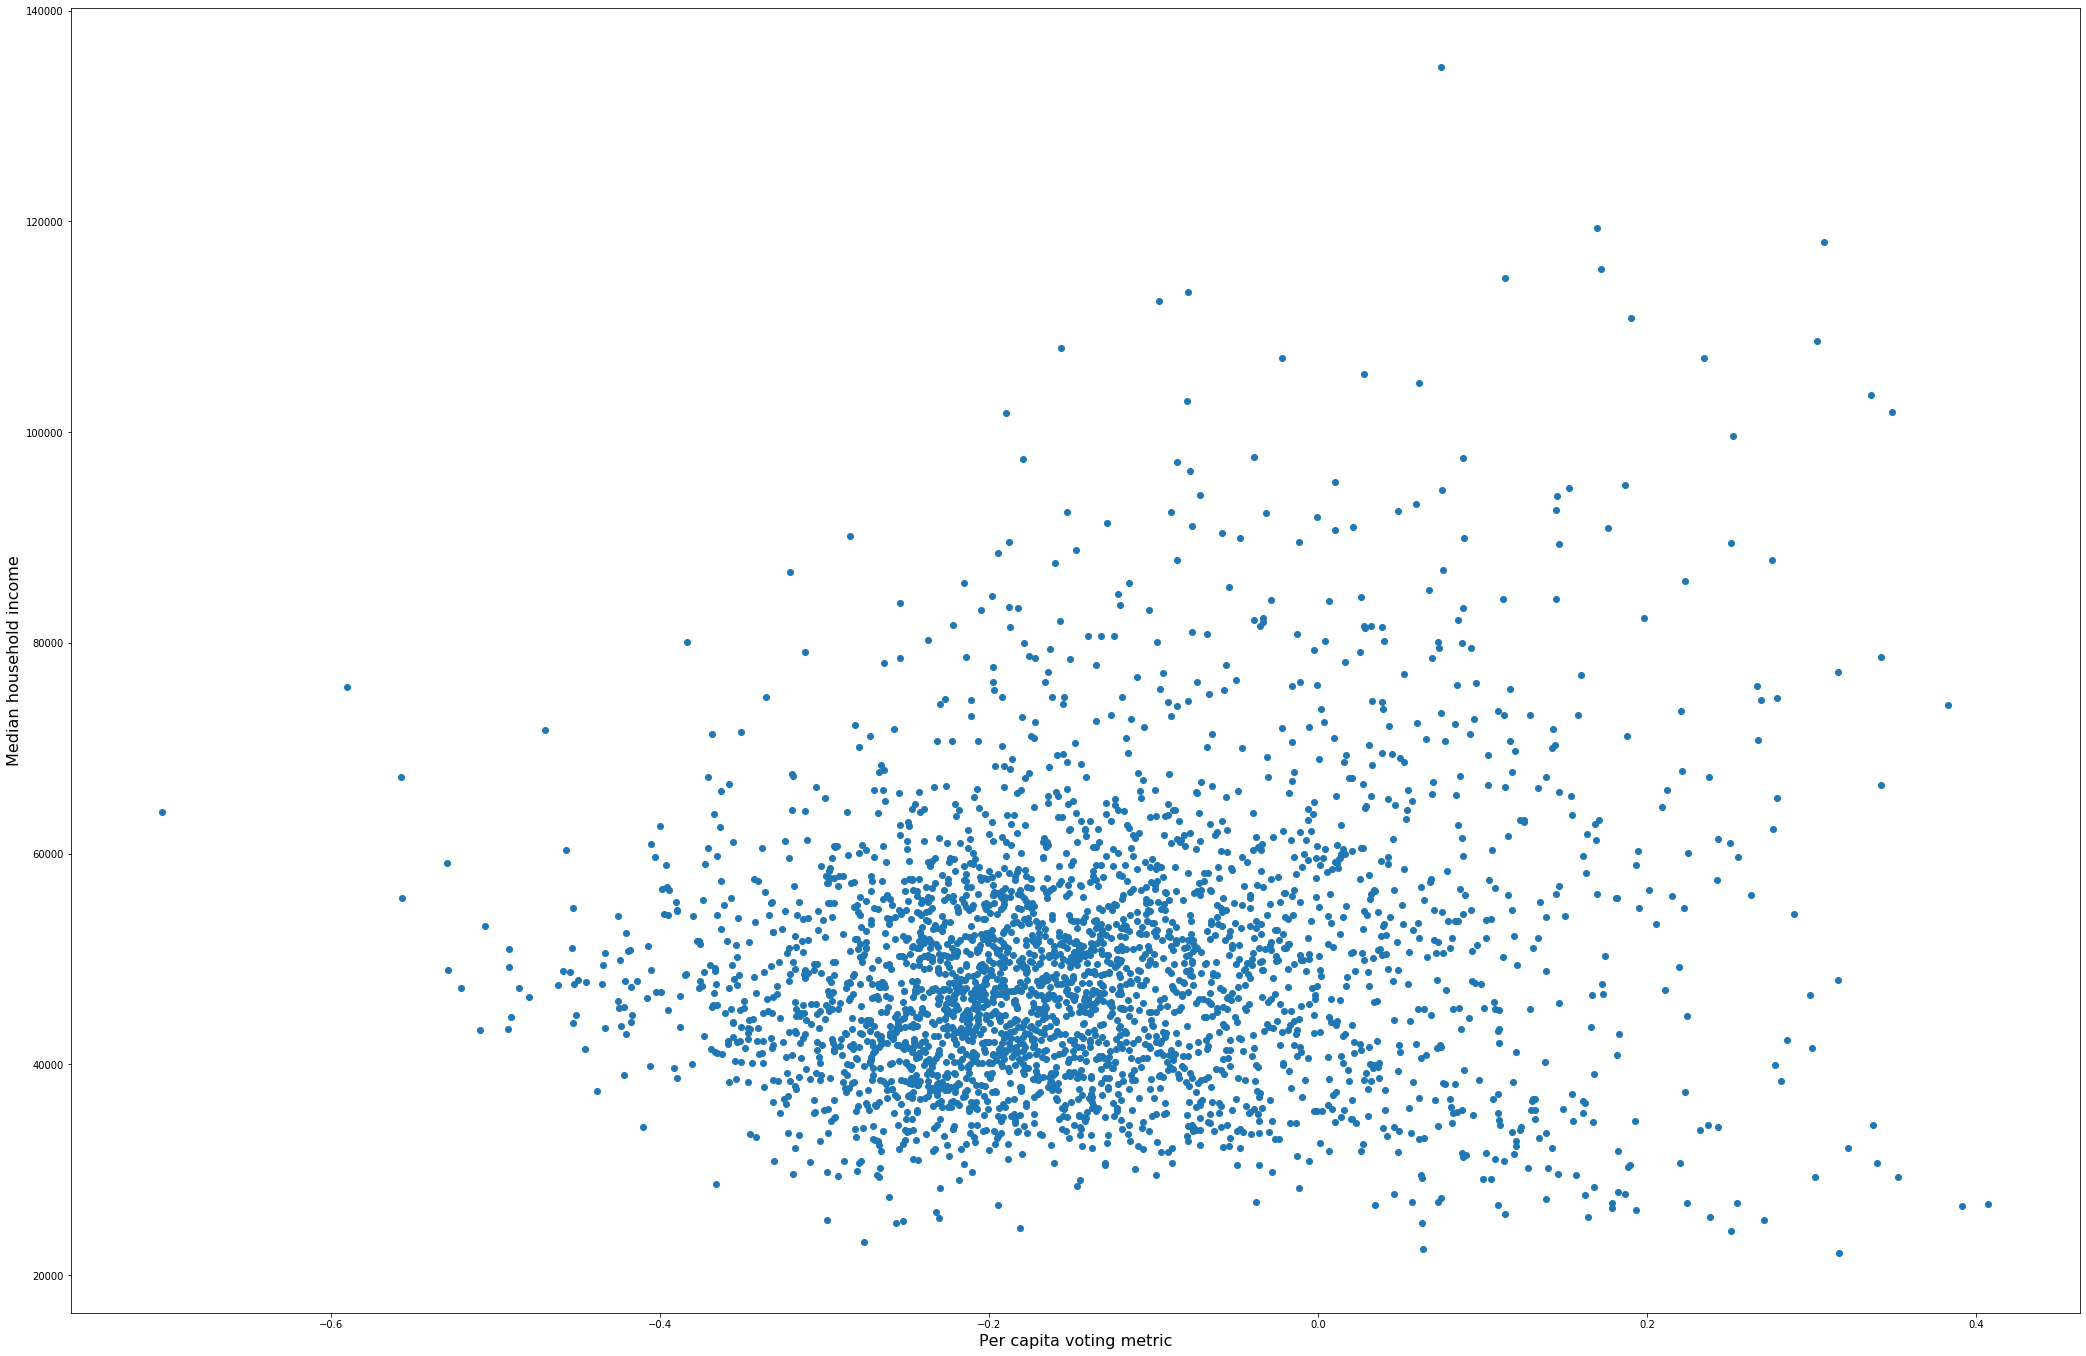

In [12]:
plt.plot(per_capita_voting_metric, merged['median_household_income'], 'o', label='data')
plt.xlabel('Per capita voting metric')
plt.ylabel('Median household income')

So as we would expect from intuition, there does seem to be a trend here of median incomes increasing as we move to the right (recall positive values indicate an excess of Clinton voters here.) Now let's plot against county poverty rate, to see if we see an opposite effect:  

Text(0, 0.5, 'Poverty rate')

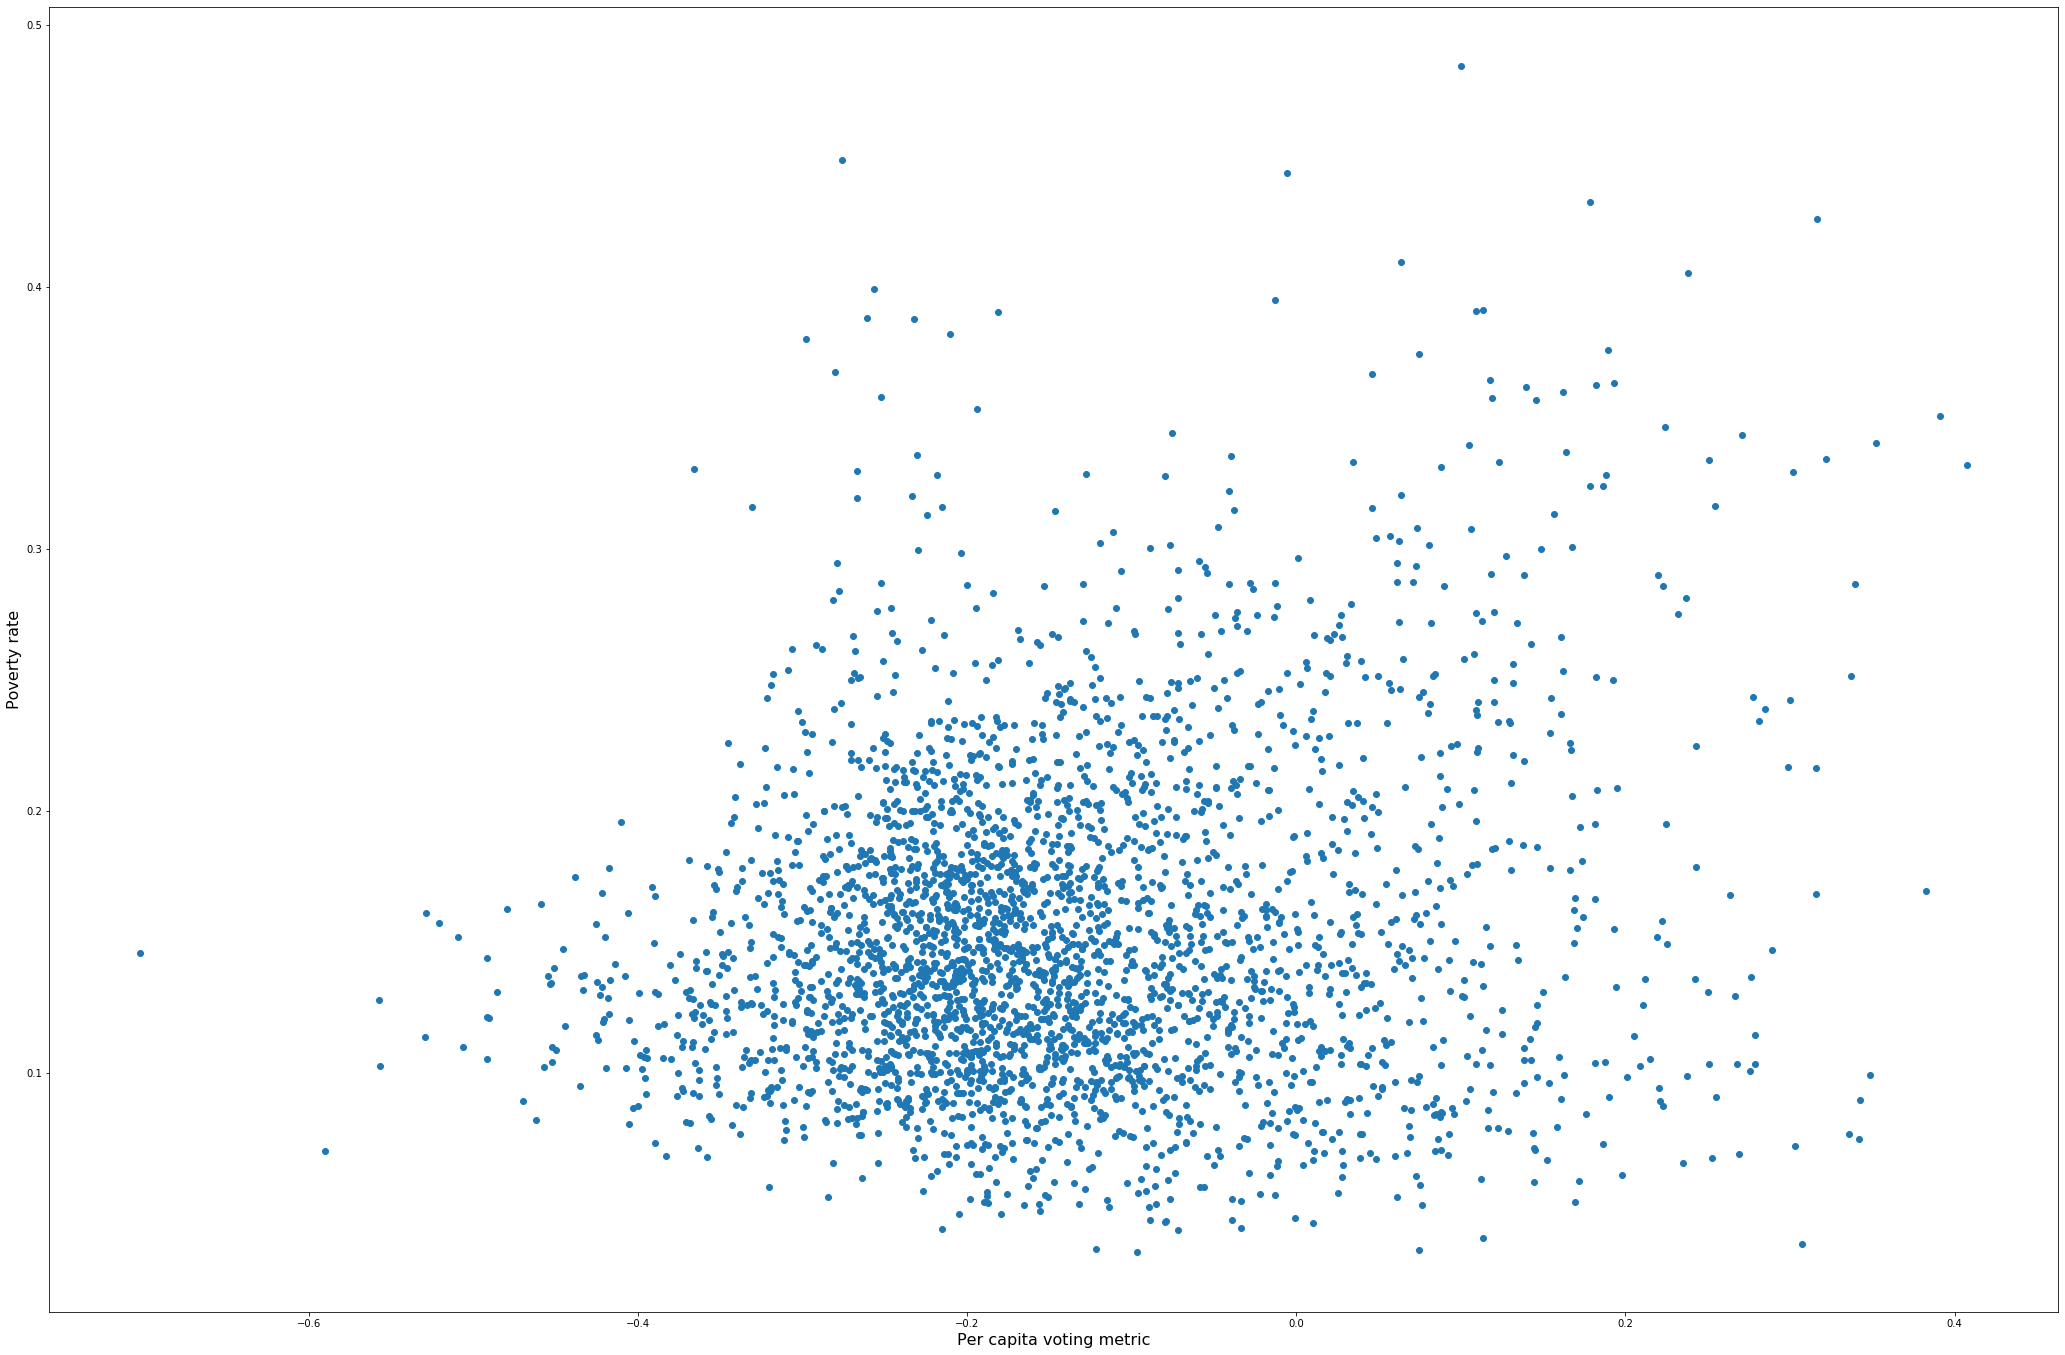

In [13]:
plt.plot(per_capita_voting_metric, merged['poverty']/merged['total_population'], 'o', label='data')
plt.xlabel('Per capita voting metric')
plt.ylabel('Poverty rate')

Here the trend is not as obvious but clearly some of the biggest outliers in poverty rate fall on the positive side. 

Now let's look at the claim that's been made that Trump counties are faring worse in the pandemic by plotting the voting metric against Covid deaths per capita:

Text(0, 0.5, 'Deaths per capita')

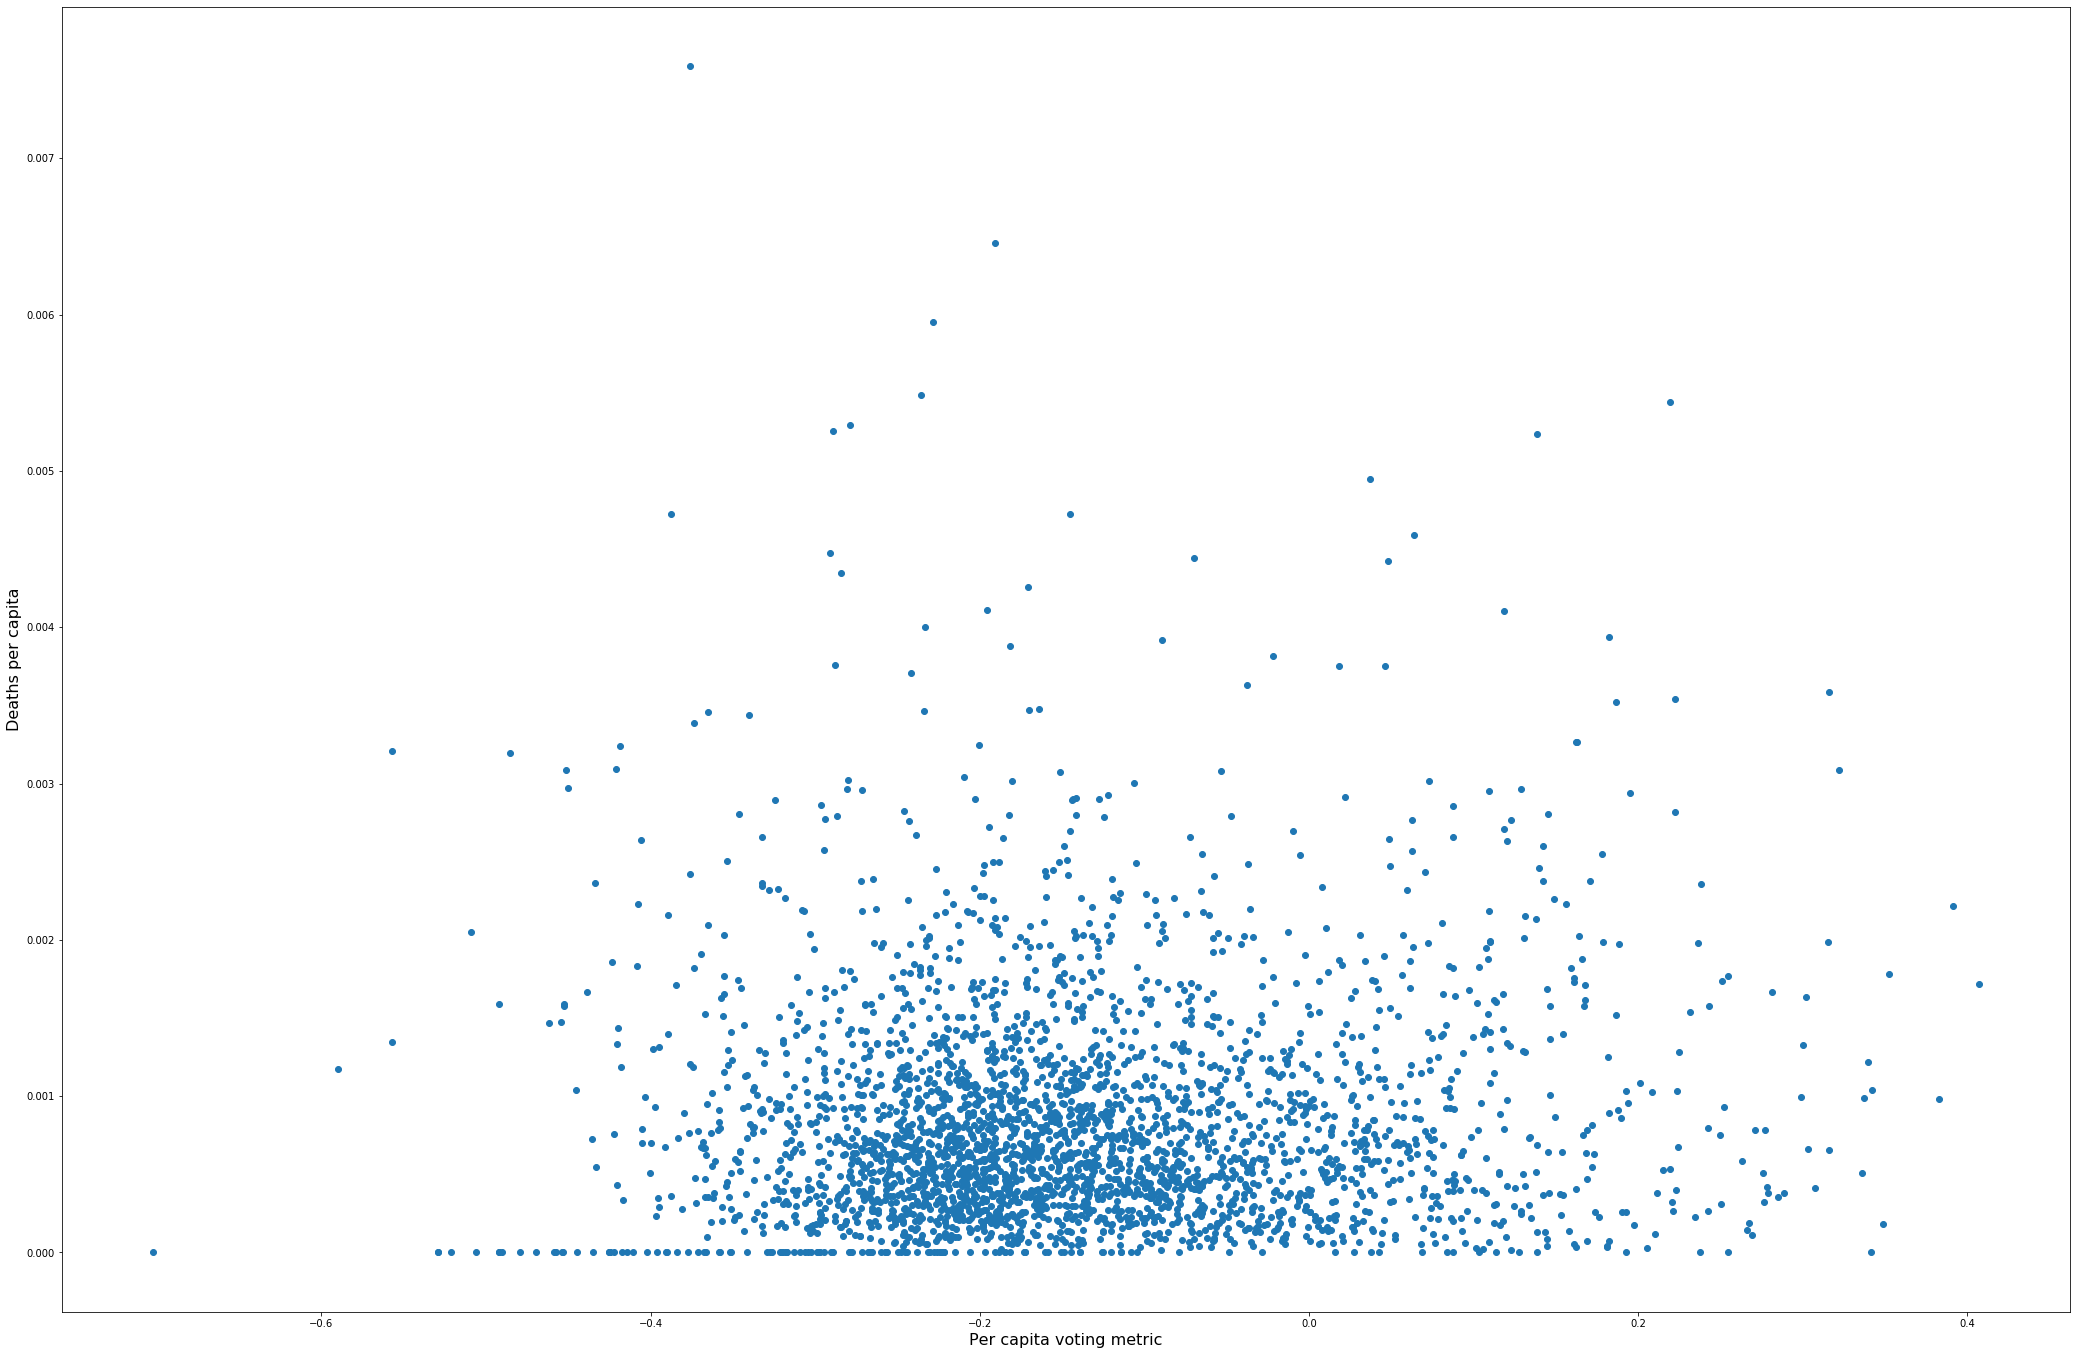

In [14]:
plt.plot(per_capita_voting_metric, most_recent_deaths_per_capita, 'o', label='data')
plt.xlabel('Per capita voting metric')
plt.ylabel('Deaths per capita')

Here the trend is again not clear. Let's instead look at the relationship between Covid deaths and voting disparity analytically.
First let's see whether counties with an excess of Clinton voters or those with an excess of Trump voters have a higher average per capita death at the terminal point of the study:

In [15]:
print("Average per capita deaths in Trump counties: " + str(most_recent_deaths_per_capita[per_capita_voting_metric < 0].mean()))
print("Average per capita deaths in Clinton counties: " + str(most_recent_deaths_per_capita[per_capita_voting_metric > 0].mean()))

Average per capita deaths in Trump counties: 0.0008235601148166336
Average per capita deaths in Clinton counties: 0.0009760259932591489


This actually shows that as of 12/4, blue counties have had more deaths per capita than red states. Let's see how this trend has changed over time by plotting the average per capita deaths in Trump and Clinton counties at each of the change dates:

Text(0, 0.5, 'Per capita deaths')

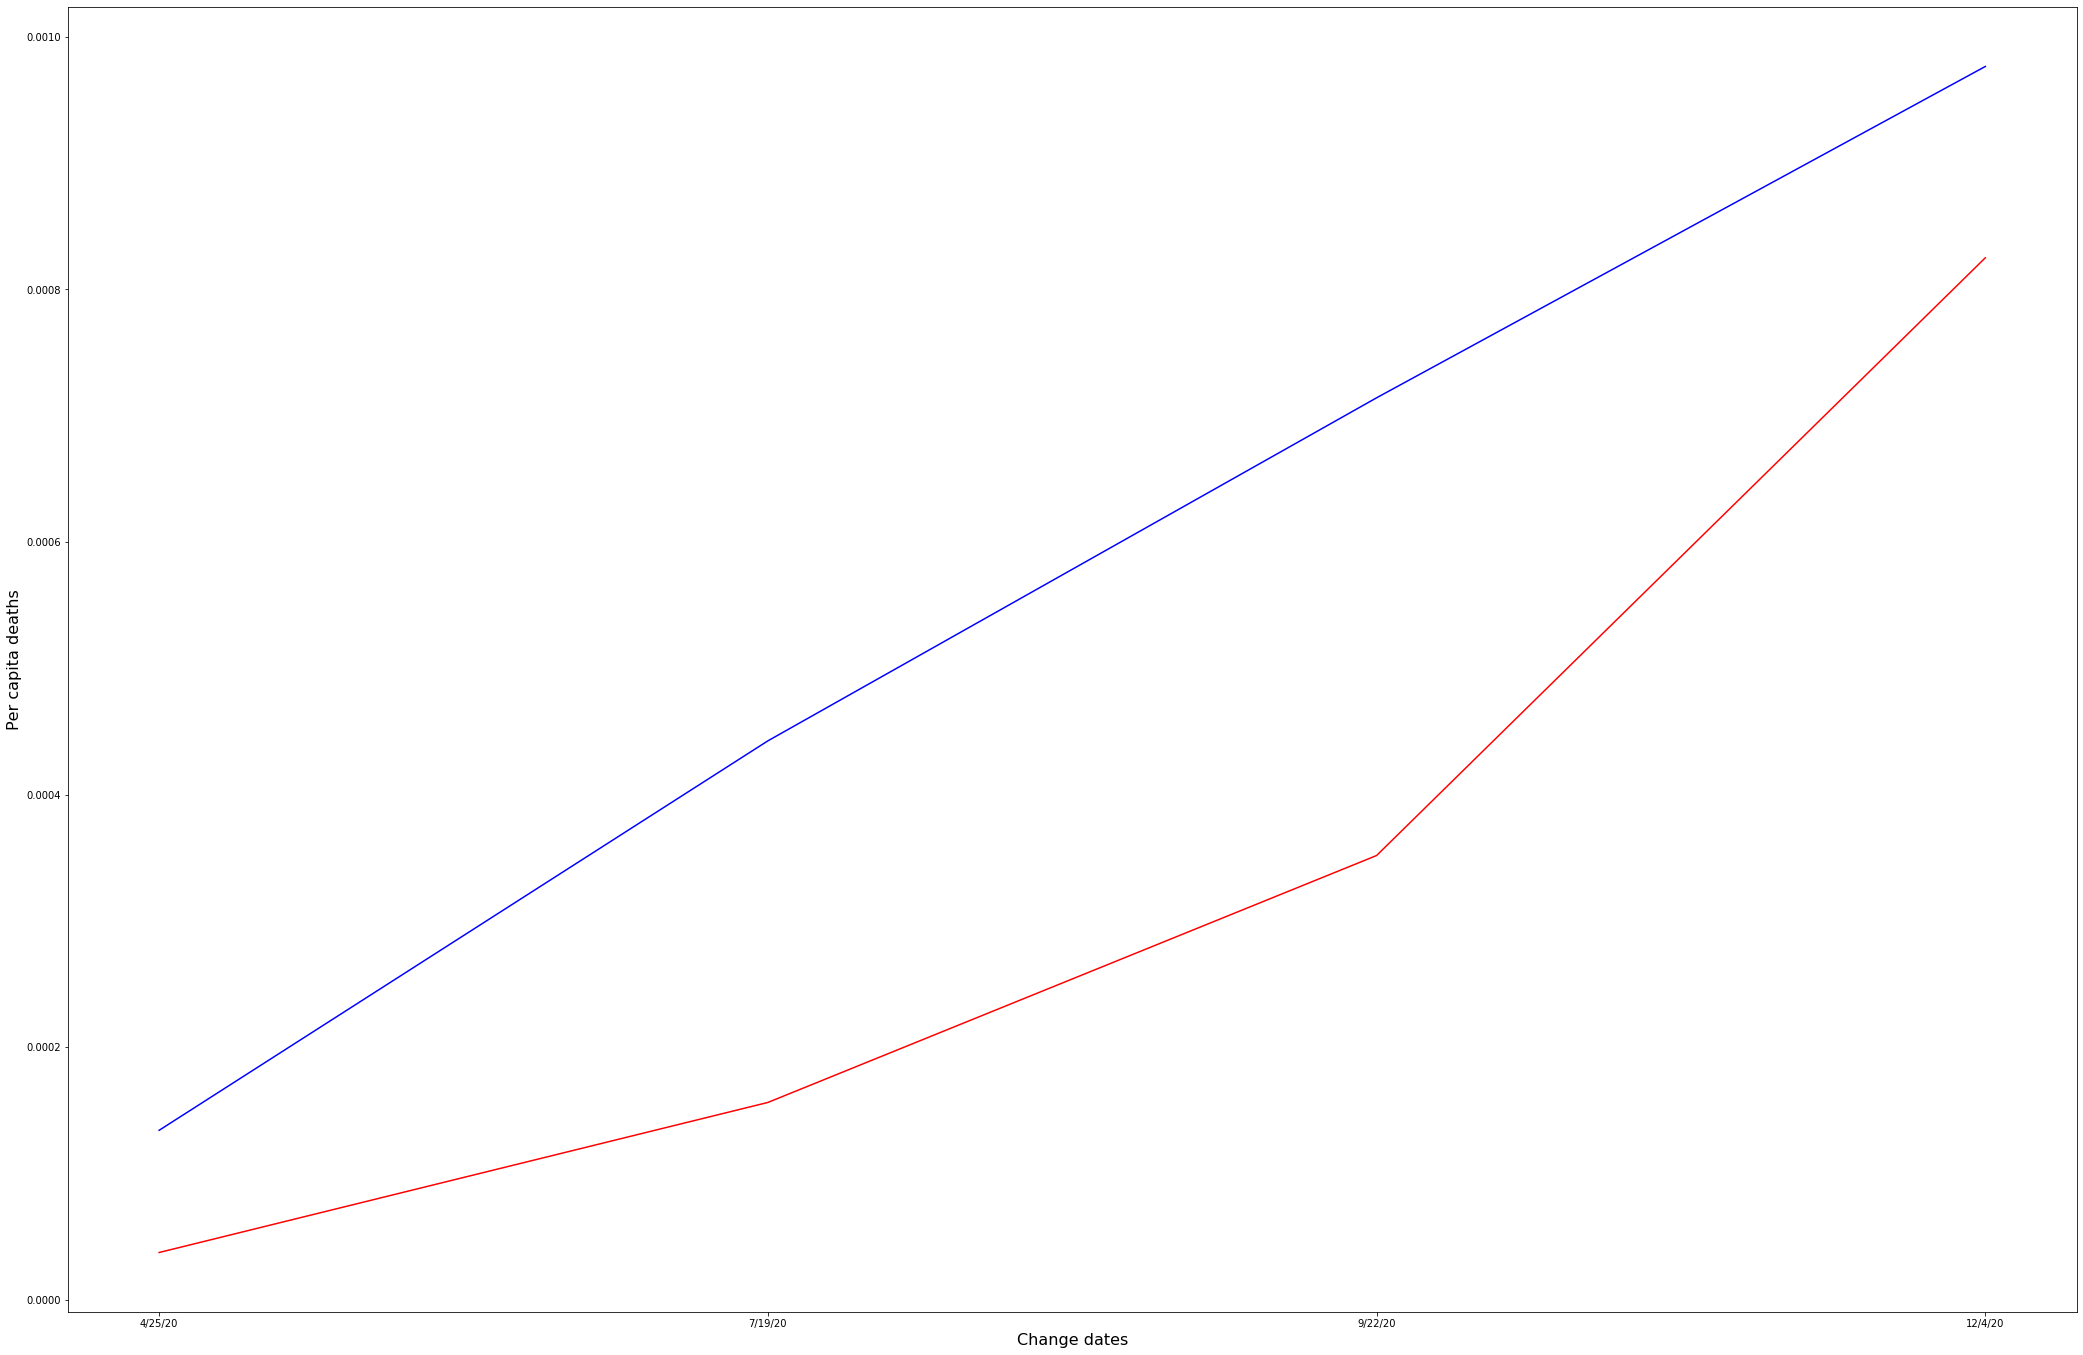

In [35]:
per_capita_deaths_over_time_in_blue_counties = []
per_capita_deaths_over_time_in_red_counties = []
for change_date in change_dates:
    per_capita_deaths_over_time_in_red_counties.append((merged[change_date]/merged['total_population'])[per_capita_voting_metric < 0].mean())
    per_capita_deaths_over_time_in_blue_counties.append((merged[change_date]/merged['total_population'])[per_capita_voting_metric > 0].mean())
plt.plot(change_dates, per_capita_deaths_over_time_in_blue_counties, label='data', color='blue')
plt.plot(change_dates, per_capita_deaths_over_time_in_red_counties, label='data',color='red')
plt.xlabel('Change dates')
plt.ylabel('Per capita deaths')

Now let's perform a regression analysis on our data.
First we standardize the regressors to make it easier to interpret results. There are two main benefits to model interpretability from standardizing:

1) We can interpret the intercept as the value of cumulative deaths our model expects in a county that had an average value for all of our regressor variables.
2) The other coefficients can be interpreted as change in cumulative deaths our model expects from an increase in the corresponding regressor of one standard deviation.

In [16]:
merged['vote_disparity'] = merged['clinton_count'] - merged['trump_count']
non_age_explanatory_vars = ['poverty', 'county_area', 'median_household_income', 'vote_disparity']
explanatory_vars = age_groups + non_age_explanatory_vars
merged[explanatory_vars] = merged[explanatory_vars].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

Now we iterate the change dates and run linear regression for each date, printing the model summary at each date:

In [17]:
results = []
for change_date in change_dates:    
    escaped_age_groups = ['Q("' + grp + '")' for grp in age_groups]    
    formula = 'Q("' + change_date + '")' + ' ~ ' + ' + '.join(non_age_explanatory_vars + escaped_age_groups)
    mod = smf.ols(formula=formula, data = merged)
    res = mod.fit()
    results.append(res)
    print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           Q("4/25/20")   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     227.9
Date:                Tue, 15 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:41:09   Log-Likelihood:                -18598.
No. Observations:                3114   AIC:                         3.724e+04
Df Residuals:                    3091   BIC:                         3.738e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

# Conclusion
The models we trained were statistically significant at each of the change points, as indicated by the results of the F tests. Additionally, most variables were significant in each of the models and in particular, our voting disparity metric was significant in each of the models. The explained variance as indicated by the adjusted R<sup>2</sup> value was increasing over the study period, starting at .616 and increasing to .870 at the terminal date of our study. Interestingly, one factor which was never significant was the county area. In the model trained over the entire time series, this was the only factor which was never significant.
While the voting disparity metric was significant at each change point, its coefficient was much lower in magnitude than all of the other variables of significance, typically by one or two orders of magnitude. This disparity is meaningful, since we standardized all of the variables before performing the analysis. The direction of the association between voting disparity and county Covid deaths was positive, meaning that an excess of Clinton voters in the county was associated with an outsized number of Covid deaths. So the upshot is that while voting distribution in a county did explain some of the variance in the difference in county Covid deaths, it was not a large factor. 

# Limitations
One major limitation of this study was that it used data from the 2016 election. While the 2020 election had already occurred when I started the project, the data wasn't yet available for all counties . It would be an interesting continuation to perform the same analysis using the data from the most recent election. Another limitation was that all of the demographic data are estimates, as the census is only conducted every 10 years. Since the census was just conducted again, it would also be interesting to perform an updated analysis with more recent data.  